In [646]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix 

from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


#### 0. Data Prep 

Dataset #1


In [647]:
# Originally Retrieved From: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/II2DB6/EARRB5&version=4.1
# URL: https://drive.google.com/file/d/1snk_L5nxyJWVQmJNqIaiG2MOBzcQrdUG/view?usp=sharing
data_demographics = pd.read_stata("Data/cumulative_2006_2018.dta")

In [648]:
data_demographics.head()

,year,case_id,weight,weight_cumulative,state,st,cd,dist,dist_up,cong,cong_up,zipcode,county_fips,tookpost,weight_post,rvweight,rvweight_post,starttime,pid3,pid3_leaner,pid7,ideo5,gender,birthyr,age,race,hispanic,educ,faminc,marstat,economy_retro,newsint,approval_pres,approval_rep,approval_sen1,approval_sen2,approval_gov,intent_pres_08,intent_pres_12,intent_pres_16,voted_pres_08,voted_pres_12,voted_pres_16,vv_regstatus,vv_party_gen,vv_party_prm,vv_turnout_gvm,vv_turnout_pvm,intent_rep,intent_rep_party,voted_rep,voted_rep_party,intent_gov,intent_gov_party,voted_gov,voted_gov_party,intent_sen,intent_sen_party,voted_sen,voted_sen_party,intent_rep_chosen,intent_sen_chosen,intent_gov_chosen,voted_rep_chosen,voted_sen_chosen,voted_gov_chosen,rep_current,rep_icpsr,sen1_current,sen1_icpsr,sen2_current,sen2_icpsr,gov_current
0,2006,439219,1.851676,1.667581,North Carolina,NC,NC-10,10,10,109,110,28645,37027,Took Post-Election Survey,NaN,NaN,NaN,2006-10-07 00:02:34,Democrat,Democrat (Including Leaners),Strong Democrat,Liberal,Female,1974,32,White,NaN,High School Graduate,10k - 20k,Divorced,Gotten Worse / Somewhat Worse,NaN,Strongly Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Approve / Somewhat Approve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voted,NaN,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Richard C. Carsner (D),,,Richard C. Carsner (D),,,Patrick T. McHenry (R),20522,Elizabeth Dole (R),40303,Richard Burr (R),29548,Michael Easley (D)
1,2006,439224,0.968308,0.872039,Ohio,OH,OH-3,3,3,109,110,45409,39113,Took Post-Election Survey,NaN,NaN,NaN,2006-10-07 00:02:53,Other,Democrat (Including Leaners),Lean Democrat,Moderate,Male,1957,49,White,NaN,Post-Grad,150k+,Married,Gotten Much Worse,NaN,Strongly Disapprove,Disapprove / Somewhat Disapprove,Strongly Disapprove,Disapprove / Somewhat Disapprove,Disapprove / Somewhat Disapprove,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voted,NaN,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,Stephanie Studebaker (D),Sherrod C. Brown (D),Ted Strickland (D),Stephanie Studebaker (D),Sherrod C. Brown (D),Ted Strickland (D),Michael R. Turner (R),20342,Mike DeWine (R),15020,George V. Voinovich (R),49903,Bob Taft (R)
2,2006,439228,1.593441,1.435020,New Jersey,NJ,NJ-1,1,1,109,110,08030,34007,Took Post-Election Survey,NaN,NaN,NaN,2006-10-07 00:02:59,Democrat,Democrat (Including Leaners),Strong Democrat,Liberal,Female,1952,54,White,NaN,High School Graduate,30k - 40k,Divorced,Gotten Much Worse,NaN,Strongly Disapprove,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,Strongly Approve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Record Of Voting,NaN,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,NaN,NaN,NaN,NaN,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,Robert E. Andrews (D),Robert Menendez (D),,Robert E. Andrews (D),Robert Menendez (D),,Robert E. Andrews (D),29132,Robert Menendez (D),29373,Frank R. Lautenberg (D),14914,Jon Corzine (D)
3,2006,439237,1.398529,1.259486,Illinois,IL,IL-9,9,9,109,110,60613,17031,Took Post-Election Survey,NaN,NaN,NaN,2006-10-07 00:03:37,Democrat,Democrat (Including Leaners),Strong Democrat,Liberal,Female,1972,34,Black,NaN,4-Year,Less than 10k,Single / Never Married,Stayed About The Same,NaN,Strongly Disapprove,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,Approve / Somewhat Approve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voted,NaN,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,[Democrat / Candidate 1],Democratic,NaN,NaN,NaN,NaN,Janice D. Schakowsky (D),,Rod Blagojevich (D),Janice D. Schakowsky (D),,Rod Blagojevich (D),Janice D. Schakowsky (D),29911,Richard Durbin (D),15021,Ba

In [649]:
inputs = ['year','st','gender', 'age', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']
targets = ['pid3']

keep = inputs + targets

data_demographics = data_demographics[(data_demographics.year == 2018) & (data_demographics.pid3.isin(['Democrat','Republican']) )]

demographics = data_demographics[keep]


In [650]:
demographics.dropna(axis=0, how='any',inplace=True)

<AxesSubplot:>

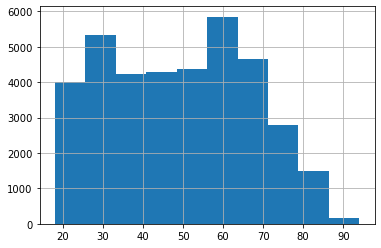

In [651]:
demographics['age'].hist()


In [652]:
pd.options.mode.chained_assignment = None  # default='warn'

demographics['age_band'] = np.NaN
demographics.loc[ (demographics['age'] >= 18) & (demographics['age'] <= 29), 'age_band'] = 'Young'
demographics.loc[ (demographics['age'] >= 30) & (demographics['age'] <= 49), 'age_band'] = 'Lower-Middle'
demographics.loc[ (demographics['age'] >= 50) & (demographics['age'] <= 69), 'age_band'] = 'Upper-Middle'
demographics.loc[ (demographics['age'] >= 70) , 'age_band'] = 'Old'

In [653]:

demographics.loc[ demographics['pid3'] == "Democrat", "Dem_Ind"] = 1
demographics.loc[ demographics['pid3'] == 'Republican', "Dem_Ind"] = 0
demographics['Dem_Ind'] = demographics['Dem_Ind'].astype(int)

In [654]:
categorical_demographics = ['st','gender', 'age_band', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']


In [655]:
demographics.head()

,year,st,gender,age,race,hispanic,educ,faminc,marstat,economy_retro,newsint,approval_pres,pid3,age_band,Dem_Ind
392756,2018,OH,Female,58,White,No,Post-Grad,150k+,Married,Stayed About The Same,Only Now And Then,Approve / Somewhat Approve,Republican,Upper-Middle,0
392757,2018,KY,Female,66,White,No,Post-Grad,10k - 20k,Divorced,Stayed About The Same,Most Of The Time,Strongly Disapprove,Democrat,Upper-Middle,1
392758,2018,AZ,Female,88,White,No,High School Graduate,20k - 30k,Widowed,Gotten Much Better,Some Of The Time,Approve / Somewhat Approve,Republican,Old,0
392760,2018,NC,Male,71,White,No,High School Graduate,50k - 60k,Married,Gotten Much Better,Some Of The Time,Strongly Approve,Republican,Old,0
392761,2018,PA,Male,86,White,No,4-Year,60k - 70k,Widowed,Gotten Better / Somewhat Better,Most Of The Time,Strongly Approve,Republican,Old,0


In [656]:
print(21290/37163)

demographics['Dem_Ind'].value_counts()


0.5728816295778059


1    21290
0    15873
Name: Dem_Ind, dtype: int64

In [657]:
X_demographics = demographics[categorical_demographics]

y_demographics = demographics.loc[:,'Dem_Ind']


In [658]:
print(X_demographics.shape)
print(y_demographics.shape)

(37163, 11)
(37163,)


In [659]:
medium_demographics = demographics.sample(n=20000, random_state = 42)

In [660]:
X_demographics_20k = medium_demographics[categorical_demographics]

y_demographics_20k = medium_demographics[categorical_demographics]

In [661]:
demographics.head()

,year,st,gender,age,race,hispanic,educ,faminc,marstat,economy_retro,newsint,approval_pres,pid3,age_band,Dem_Ind
392756,2018,OH,Female,58,White,No,Post-Grad,150k+,Married,Stayed About The Same,Only Now And Then,Approve / Somewhat Approve,Republican,Upper-Middle,0
392757,2018,KY,Female,66,White,No,Post-Grad,10k - 20k,Divorced,Stayed About The Same,Most Of The Time,Strongly Disapprove,Democrat,Upper-Middle,1
392758,2018,AZ,Female,88,White,No,High School Graduate,20k - 30k,Widowed,Gotten Much Better,Some Of The Time,Approve / Somewhat Approve,Republican,Old,0
392760,2018,NC,Male,71,White,No,High School Graduate,50k - 60k,Married,Gotten Much Better,Some Of The Time,Strongly Approve,Republican,Old,0
392761,2018,PA,Male,86,White,No,4-Year,60k - 70k,Widowed,Gotten Better / Somewhat Better,Most Of The Time,Strongly Approve,Republican,Old,0


In [662]:
small_demographics = demographics.sample(n=10000, random_state = 42)

In [663]:
small_demographics['Dem_Ind'].value_counts()

1    5678
0    4322
Name: Dem_Ind, dtype: int64

In [664]:
X_demographics_10k = small_demographics[categorical_demographics]

y_demographics_10k = small_demographics.loc[:,'Dem_Ind']


Dataset #2

In [665]:
# Originall Retrieved From: http://archive.ics.uci.edu/ml/datasets/Adult
# CSV Retrieved From: https://www.kaggle.com/uciml/adult-census-income
# URL: https://drive.google.com/file/d/1wuWJPeacMhHQSXdITZx1_pktoU-ZRb8n/view?usp=sharing
data_income = pd.read_csv("Data/adult.csv")

In [666]:
print(data_income.shape)

(32561, 15)


In [667]:
data_income.head()


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [668]:
# Response Variable 
data_income.loc[ data_income['income'] == ">50K", "income"] = 1
data_income.loc[ data_income['income'] == '<=50K', "income"] = 0
data_income['income'] = data_income['income'].astype(int)

In [669]:
# Feature Engineering
data_income['native_USA'] = 0 
data_income.loc[ data_income['native.country'] == "United-States", "native_USA"] = 1
data_income.loc[ data_income['native.country'] != "United-States", "native_USA"] = 0

<AxesSubplot:>

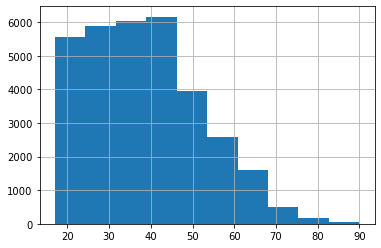

In [670]:
data_income.age.hist()

In [671]:
data_income['age_band'] = np.NaN
data_income.loc[ (data_income['age'] <= 29), 'age_band'] = 'Young'
data_income.loc[ (data_income['age'] >= 30) & (data_income['age'] <= 49), 'age_band'] = 'Lower-Middle'
data_income.loc[ (data_income['age'] >= 50) & (data_income['age'] <= 69), 'age_band'] = 'Upper-Middle'
data_income.loc[ (data_income['age'] >= 70) , 'age_band'] = 'Old'

In [672]:
data_income['age_band'].value_counts()

Lower-Middle    15788
Young            9711
Upper-Middle     6433
Old               629
Name: age_band, dtype: int64

<AxesSubplot:>

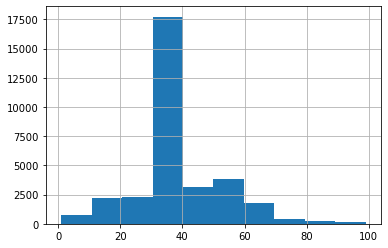

In [673]:
data_income['hours.per.week'].hist()


In [674]:
data_income['hours_band'] = np.NaN
data_income.loc[ (data_income['hours.per.week']) < 40, "hours_band"] = 'Low'
data_income.loc[ (data_income['hours.per.week']) == 40, "hours_band"] = 'Average'
data_income.loc[ (data_income['hours.per.week']) > 40, "hours_band"] = 'High'

In [675]:
data_income['native_USA'].value_counts()

1    29170
0     3391
Name: native_USA, dtype: int64

In [676]:
data_income['hours_band'].value_counts()

Average    15217
High        9581
Low         7763
Name: hours_band, dtype: int64

In [677]:
data_income.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income', 'native_USA', 'age_band', 'hours_band'],
      dtype='object')

In [678]:
categorical_income = ['workclass','education','marital.status','occupation','relationship','race','sex','native_USA','age_band','hours_band']


In [679]:
data_income['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [680]:
data_income.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,native_USA,age_band,hours_band
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,0,1,Old,Average
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,1,Old,Low
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,0,1,Upper-Middle,Average
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,1,Upper-Middle,Average
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,1,Lower-Middle,Average


In [681]:
small_income = data_income.sample(10000,random_state=42)

In [682]:
X_income = small_income[categorical_income]

y_income = small_income.loc[:,'income']


General Use Functions

In [683]:
from sklearn.preprocessing import OneHotEncoder

def prep_data(X, y, categoricalVars):

    encoder = OneHotEncoder(sparse=False)
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categoricalVars]))
    X_encoded.columns = encoder.get_feature_names(categoricalVars)
    X.drop(categoricalVars, axis = 1, inplace = True)
    if X.shape[1] > 0:
        OH_X = pd.concat([X, pd.DataFrame(X_encoded, index=X.index)], axis = 1)
    else:
        OH_X = X_encoded 
        
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(OH_X, y, test_size = .30, train_size = .70, random_state = 42)
    return(X_Train, X_Test, Y_Train, Y_Test)

In [684]:
X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k = prep_data(X_demographics_10k, y_demographics_10k, categorical_demographics)

In [685]:
X_Train_Demographics_10k.shape

(7000, 108)

In [686]:
X_Train_Demographics_10k.head()

,st_AK,st_AL,st_AR,st_AZ,st_CA,st_CO,st_CT,st_DC,st_DE,st_FL,st_GA,st_HI,st_IA,st_ID,st_IL,st_IN,st_KS,st_KY,st_LA,st_MA,st_MD,st_ME,st_MI,st_MN,st_MO,st_MS,st_MT,st_NC,st_ND,st_NE,st_NH,st_NJ,st_NM,st_NV,st_NY,st_OH,st_OK,st_OR,st_PA,st_RI,st_SC,st_SD,st_TN,st_TX,st_UT,st_VA,st_VT,st_WA,st_WI,st_WV,st_WY,gender_Female,gender_Male,age_band_Lower-Middle,age_band_Old,age_band_Upper-Middle,age_band_Young,race_Asian,race_Black,race_Hispanic,race_Middle Eastern,race_Mixed,race_Native American,race_Other,race_White,hispanic_No,hispanic_Yes,educ_2-Year,educ_4-Year,educ_High School Graduate,educ_No HS,educ_Post-Grad,educ_Some College,faminc_100k - 120k,faminc_10k - 20k,faminc_120k - 150k,faminc_150k+,faminc_20k - 30k,faminc_30k - 40k,faminc_40k - 50k,faminc_50k - 60k,faminc_60k - 70k,faminc_70k - 80k,faminc_80k - 100k,faminc_Less than 10k,faminc_Prefer not to say,marstat_Divorced,marstat_Domestic Partnership,marstat_Married,marstat_Separated,marstat_Single / Never Married,marstat_Widowed,economy_retro_Gotten Better / Somewhat Better,economy_retro_Gotten Much Better,economy_retro_Gotten Much Worse,economy_retro_Gotten Worse / Somewhat Worse,economy_retro_Not Sure,economy_retro_Stayed About The Same,newsint_Don't Know,newsint_Hardly At All,newsint_Most Of The Time,newsint_Only Now And Then,newsint_Some Of The Time,approval_pres_Approve / Somewhat Approve,approval_pres_Disapprove / Somewhat Disapprove,approval_pres_Never Heard / Not Sure,approval_pres_Strongly Approve,approval_pres_Strongly Disapprove
9069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [687]:
X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income = prep_data(X_income, y_income, categorical_income)

In [688]:
X_Train_Income.head()

,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital.status_Divorced,marital.status_Married-AF-spouse,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,marital.status_Never-married,marital.status_Separated,marital.status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native_USA_0,native_USA_1,age_band_Lower-Middle,age_band_Old,age_band_Upper-Middle,age_band_Young,hours_band_Average,hours_band_High,hours_band_Low
9069,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2603,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7738,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1579,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5058,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [689]:
X_Train_Income.shape

(7000, 69)

#### Learning Curve - Initial Analysis

In [596]:
from sklearn.model_selection import learning_curve

# From SKLEARN DOCS: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def make_learning_curve(estimator, X, y, title):
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, return_times = True, scoring = 'f1')

    _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    #if ylim is not None:
    #    axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print(test_scores_mean)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")


    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    plt.show()

#### 1. Decision Trees

Polling Data - Default

[0.87463104 0.87651336 0.87314808 0.87938293 0.88081797]


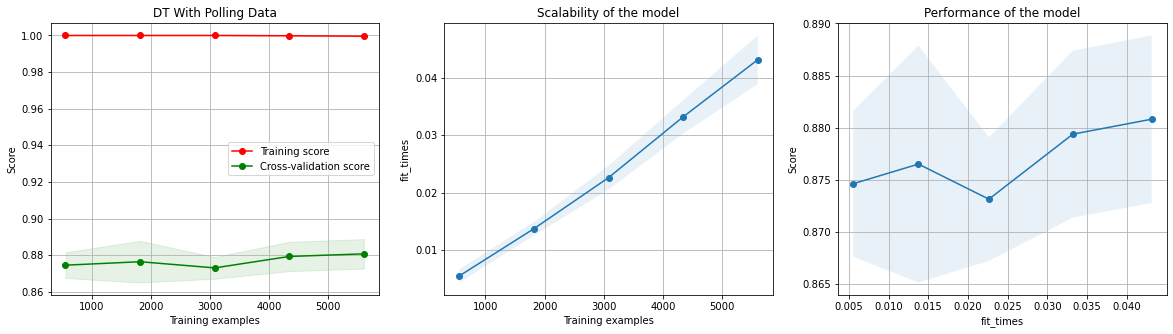

1.1241490840911865


In [598]:
start = time.time()

make_learning_curve(DecisionTreeClassifier(random_state=42), X_Train_Demographics_10k, Y_Train_Demographics_10k, "DT With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

Polling Data - Best

[0.90695439 0.91374558 0.91903604 0.92075216 0.92398328]


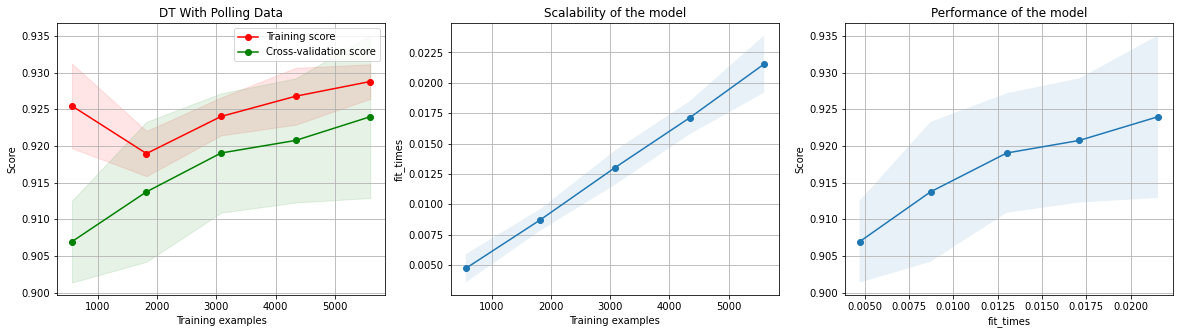

0.8562800884246826


In [599]:
start = time.time()

make_learning_curve(DecisionTreeClassifier(
                    random_state=42,
                    criterion='gini', max_depth= 7, min_samples_leaf= 11, splitter= 'best'), 
                    X_Train_Demographics_10k, Y_Train_Demographics_10k, "DT With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

Income Data - Default

[0.51070789 0.52470431 0.51822874 0.52302647 0.53576978]


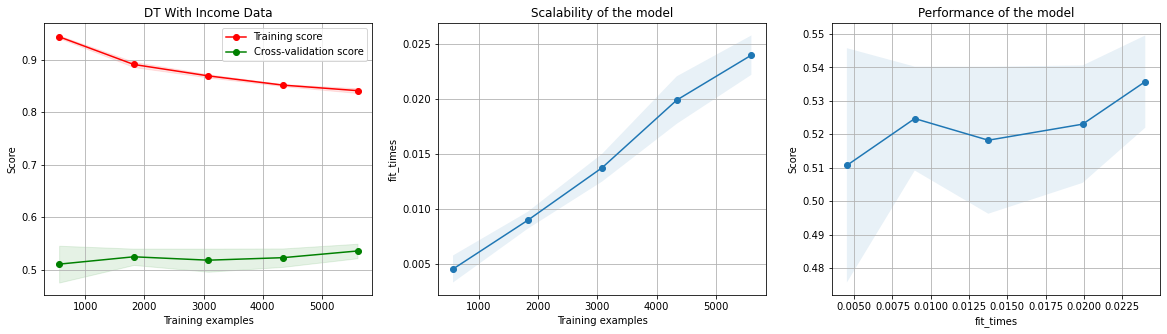

0.9390091896057129


In [600]:
start = time.time()

make_learning_curve(DecisionTreeClassifier(random_state=42), X_Train_Income, Y_Train_Income, "DT With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

Income Data - Best

[0.54020894 0.56846515 0.5694725  0.54549072 0.58234287]


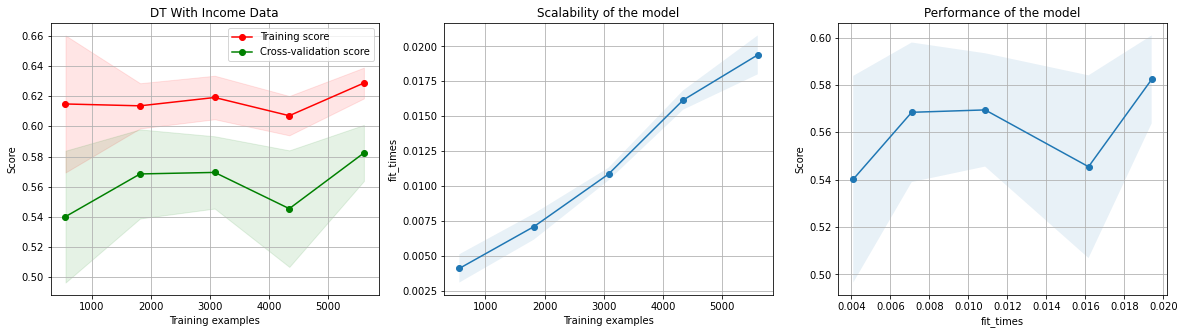

0.7953381538391113


In [601]:
start = time.time()

make_learning_curve(DecisionTreeClassifier(
                    random_state=42,
                    criterion= 'gini', max_depth=17, min_samples_leaf= 17, splitter= 'best'),
                    X_Train_Income, Y_Train_Income, "DT With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

In [548]:
#from sklearn.model_selection import GridSearchCV 

def make_GridSearchCV_DT(X_Train, Y_Train):
    
    criterions = ['gini', 'entropy']
    splitters = ['best', 'random']
    max_depths = list(np.arange(1, 20, 2))
    min_samples_leaf = list(np.arange(10, 20, 1))

    param_grid = {'criterion': criterions, 'splitter': splitters, 
                  'max_depth': max_depths, 
                  'min_samples_leaf':min_samples_leaf}

    classifier = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=param_grid, 
                       scoring='f1',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [349]:
start = time.time()

make_GridSearchCV_DT(X_Train_Demographics_10k, Y_Train_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)

0.9240992712254925
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 11, 'splitter': 'random'}
51.09125876426697


In [350]:
start = time.time()

make_GridSearchCV_DT(X_Train_Income, Y_Train_Income)

end = time.time()
elapsed = end - start
print(elapsed)

0.5823428742755026
{'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 17, 'splitter': 'best'}
36.961660861968994


In [589]:
def dt_min_samples_leaf(X_Train, X_Test, Y_Train, Y_Test, criterion, splitter, datasetname):

    min_samples = list(np.arange(1,21,1))
    f1_scores_test = []
    f1_scores_train = []
    for s in min_samples:
        classifier = DecisionTreeClassifier(criterion=criterion,splitter=splitter,min_samples_leaf = s,random_state=42)
        classifier.fit(X_Train, Y_Train)

        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_test.append(f1_score)

        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_train.append(f1_score)

    plt.plot(min_samples, f1_scores_test,label = "Test")
    plt.plot(min_samples, f1_scores_train, label = "Train")
    plt.xlabel("Min Samples Leaf")
    plt.ylabel("F1 Score")
    plt.title(datasetname + "\n" + criterion + " criterion and \n" + splitter + " splitter")
    plt.legend()
    plt.show()

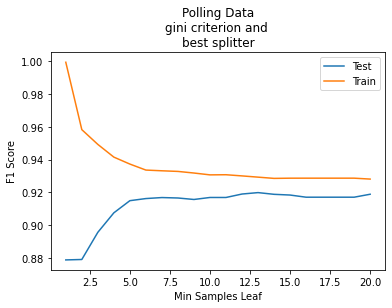

1.3825969696044922


In [590]:
start = time.time()

dt_min_samples_leaf(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 'gini', 'best', "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

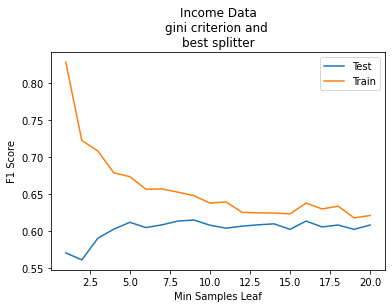

1.037926197052002


In [594]:
start = time.time()

dt_min_samples_leaf(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, 'gini', 'best', "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

In [503]:

def dt_depths(X_Train, X_Test, Y_Train, Y_Test, criterion, splitter, datasetname):

    depths = list(np.arange(1,21,1))
    f1_scores_test = []
    f1_scores_train = []
    for d in depths:
        classifier = DecisionTreeClassifier(criterion=criterion,splitter=splitter,max_depth = d,random_state=42)
        classifier.fit(X_Train, Y_Train)

        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_test.append(f1_score)

        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_train.append(f1_score)

    plt.plot(depths, f1_scores_test,label = "Test")
    plt.plot(depths, f1_scores_train, label = "Train")
    plt.xlabel("Max Depth")
    plt.ylabel("F1 Score")
    plt.title(datasetname + "\n" + criterion + " criterion and \n" + splitter + " splitter")
    plt.legend()
    plt.show()

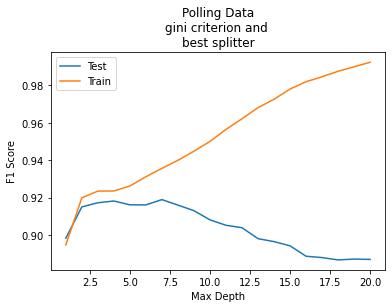

1.2278892993927002


In [504]:
start = time.time()
dt_depths(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 'gini', 'best', "Polling Data")
end = time.time()
elapsed = end-start
print(elapsed)

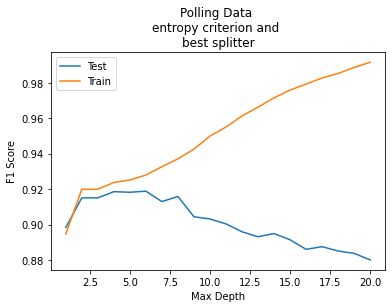

1.1858367919921875


In [505]:
start = time.time()

dt_depths(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 'entropy', 'best', "Polling Data ")

end = time.time()
elapsed = end-start
print(elapsed)

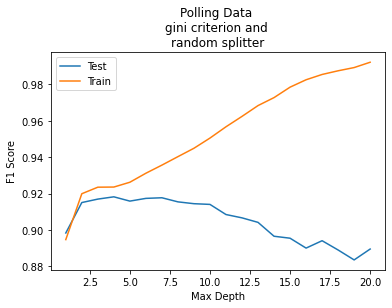

1.1037020683288574


In [506]:
start = time.time()
dt_depths(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 'gini', 'random', "Polling Data ")

end = time.time()
elapsed = end-start
print(elapsed)

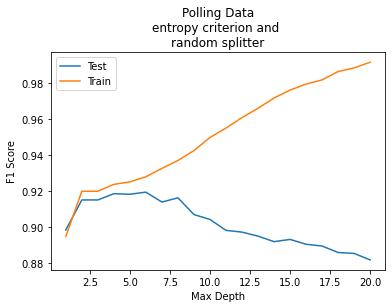

1.1212821006774902


In [507]:
start = time.time()

dt_depths(X_Train_Demographics_10k, X_Test_Demographics_10k, \
          Y_Train_Demographics_10k, Y_Test_Demographics_10k, 'entropy', 'random', "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

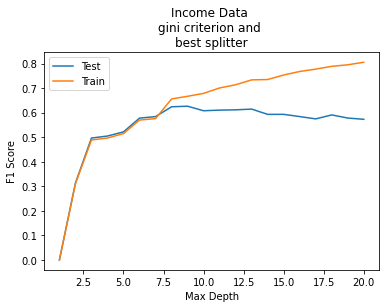

0.9286439418792725


In [595]:
start = time.time()
dt_depths(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, 'gini', 'best', "Income Data ")

end = time.time()
elapsed = end-start
print(elapsed)

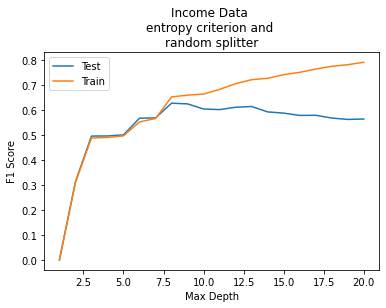

0.8014709949493408


In [508]:
start = time.time()
dt_depths(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, 'entropy', 'random', "Income Data ")

end = time.time()
elapsed = end-start
print(elapsed)

In [169]:
#from sklearn.tree import DecisionTreeClassifier 
#from sklearn.metrics import confusion_matrix 

def make_decision_tree(criterion,splitter,max_depth, sample, group, X_Train, X_Test, Y_Train, Y_Test):

    classifier = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth = max_depth, min_samples_leaf=sample,random_state=42)
    classifier.fit(X_Train, Y_Train)

    if group == "TEST":
        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        
    else:
        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()


    accuracy = (tn + tp) / (tn + tp + fn + fp)
    f1_score = (2*tp) / (2*tp + fp + fn)
    precision_1 = tp / (tp + fp)
    precision_0 = tn / (tn + fn)
    recall_1 =  tp / (tp + fn)
    recall_0 =  tn / (tn + fp)
    return(accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn)

In [170]:
def make_dt_experiments(X_Train, X_Test, Y_Train, Y_Test):
    
    accuracy_list = []
    f1_list = []
    precision_1_list = []
    precision_0_list = []
    recall_1_list = []
    recall_0_list = []
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []

    #criterions = ['gini', 'entropy']
    criterions = ['gini']
    #splitters = ['best', 'random']
    splitters = ['best']
    max_depths = list(np.arange(1, 21, 1))
    min_samples_leaf = list(np.arange(1,20,1))
    groups = ['TEST','TRAIN']

    criterion_list = []
    splitter_list = []
    depth_list = []
    samples_list = []
    group_list = []


    for c in criterions:
        for s in splitters:
            for d in max_depths:  
                for sample in min_samples_leaf:
                    for group in groups:
                        
                        accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn = make_decision_tree(c, s, d, sample, group, X_Train, X_Test, Y_Train, Y_Test)

                        accuracy_list.append(accuracy)
                        f1_list.append(f1_score)
                        precision_1_list.append(precision_1)
                        precision_0_list.append(precision_0)
                        recall_1_list.append(recall_1)
                        recall_0_list.append(recall_0)
                        criterion_list.append(c)
                        splitter_list.append(s)
                        depth_list.append(d)
                        samples_list.append(sample)
                        group_list.append(group)
                        tp_list.append(tp)
                        tn_list.append(tn)
                        fp_list.append(fp)
                        fn_list.append(fn)

    results_dt = pd.DataFrame(zip(criterion_list, splitter_list, depth_list, samples_list, group_list, accuracy_list, f1_list, precision_1_list,precision_0_list,recall_1_list,recall_0_list, tp_list, tn_list, fp_list, fn_list), 
                            columns = ["Criterion", 'Splitter','Max_Depth',"Min_Samples_Leaf", "Test_Group",'Accuracy','F1_Score','Precision_1','Precision_0','Recall_1','Recall_0', 'TP', 'TN', 'FP', 'FN'])

    return(results_dt)

In [171]:
start = time.time()
DT_Votes =  make_dt_experiments(X_Train_Votes, X_Test_Votes, Y_Train_Votes, Y_Test_Votes)
end = time.time()
elapsed = end - start
print(elapsed)

3.6329941749572754


In [172]:
DT_Votes.head()

,Criterion,Splitter,Max_Depth,Min_Samples_Leaf,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
0,gini,best,1,1,TEST,0.969466,0.976190,0.987952,0.937500,0.964706,0.978261,82,45,1,3
1,gini,best,1,1,TRAIN,0.950658,0.957983,0.977143,0.914729,0.939560,0.967213,171,118,4,11
2,gini,best,1,2,TEST,0.969466,0.976190,0.987952,0.937500,0.964706,0.978261,82,45,1,3
3,gini,best,1,2,TRAIN,0.950658,0.957983,0.977143,0.914729,0.939560,0.967213,171,118,4,11
4,gini,best,1,3,TEST,0.969466,0.976190,0.987952,0.937500,0.964706,0.978261,82,45,1,3


In [173]:
start = time.time()

DT_Demographics =  make_dt_experiments(X_Train_Demographics, X_Test_Demographics, Y_Train_Demographics, Y_Test_Demographics)

end = time.time()
elapsed = end - start
print(elapsed)

165.68352508544922


In [174]:
DT_Demographics.head()

,Criterion,Splitter,Max_Depth,Min_Samples_Leaf,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
0,gini,best,1,1,TEST,0.887882,0.895205,0.950846,0.823997,0.845715,0.942928,5339,4560,276,974
1,gini,best,1,1,TRAIN,0.884716,0.893149,0.957525,0.810972,0.836883,0.949624,12534,10481,556,2443
2,gini,best,1,2,TEST,0.887882,0.895205,0.950846,0.823997,0.845715,0.942928,5339,4560,276,974
3,gini,best,1,2,TRAIN,0.884716,0.893149,0.957525,0.810972,0.836883,0.949624,12534,10481,556,2443
4,gini,best,1,3,TEST,0.887882,0.895205,0.950846,0.823997,0.845715,0.942928,5339,4560,276,974


In [175]:
start = time.time()

DT_Demographics_10k =  make_dt_experiments(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)

33.55196022987366


In [176]:
DT_Demographics_10k.tail()

,Criterion,Splitter,Max_Depth,Min_Samples_Leaf,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
755,gini,best,20,17,TRAIN,0.918429,0.928616,0.922275,0.913219,0.935045,0.896631,3714,2715,313,258
756,gini,best,20,18,TEST,0.905000,0.916982,0.911407,0.896308,0.922626,0.881762,1574,1141,153,132
757,gini,best,20,18,TRAIN,0.918429,0.928616,0.922275,0.913219,0.935045,0.896631,3714,2715,313,258
758,gini,best,20,19,TEST,0.905000,0.916982,0.911407,0.896308,0.922626,0.881762,1574,1141,153,132
759,gini,best,20,19,TRAIN,0.918429,0.928616,0.922275,0.913219,0.935045,0.896631,3714,2715,313,258


In [177]:
max(DT_Demographics_10k[(DT_Demographics_10k.Test_Group == 'TEST')]['F1_Score'])

0.9209138840070299

#### 2) Artificial Neural Network

[0.89685473 0.90159746 0.9004431  0.90082128 0.89480144]


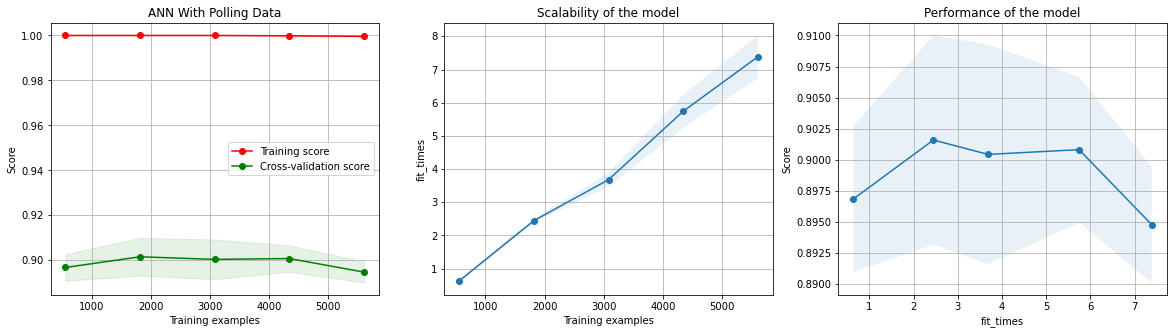

100.08318591117859


In [602]:
start = time.time()

make_learning_curve(MLPClassifier(max_iter=1000,random_state=42), X_Train_Demographics_10k, Y_Train_Demographics_10k, "ANN With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.88702237 0.91448768 0.91984927 0.92481883 0.92557206]


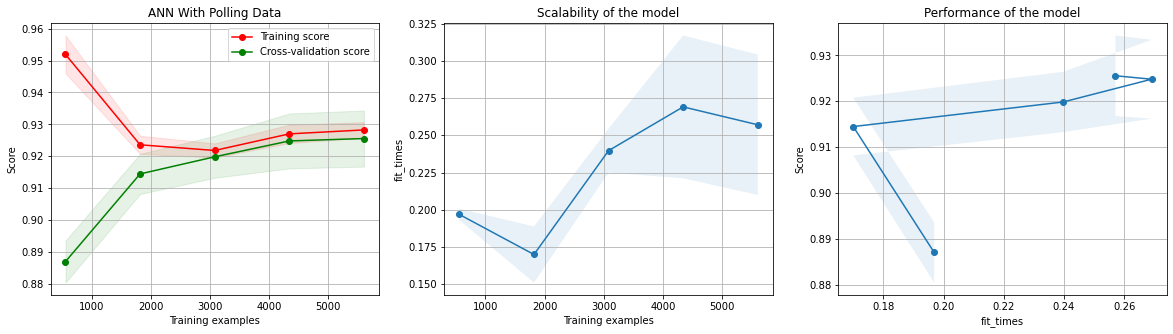

6.202666997909546


In [604]:
start = time.time()

make_learning_curve(MLPClassifier(random_state=42,
                    max_iter=2000, activation='identity',hidden_layer_sizes= 1, solver= 'adam', learning_rate_init=0.01),
                    X_Train_Demographics_10k, Y_Train_Demographics_10k, "ANN With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.88702237 0.91448768 0.91984927 0.92481883 0.92557206]


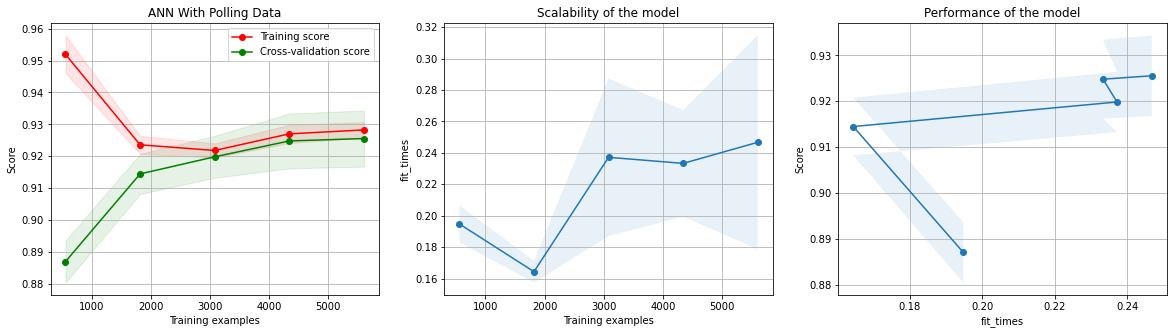

5.841897249221802


In [605]:
start = time.time()

make_learning_curve(MLPClassifier(random_state=42,
                    max_iter=2000, activation='identity',hidden_layer_sizes= 1, solver= 'adam', learning_rate_init=0.01),
                    X_Train_Demographics_10k, Y_Train_Demographics_10k, "ANN With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.54992558 0.56323096 0.56462732 0.56716158 0.56453953]


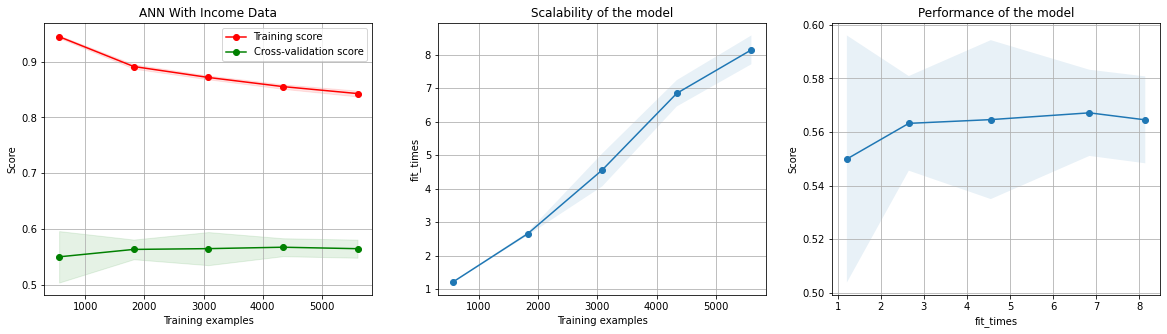

117.58033514022827


In [606]:
start = time.time()

make_learning_curve(MLPClassifier(max_iter=1000,random_state=42), X_Train_Income, Y_Train_Income, "ANN With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.60613774 0.62309712 0.64951142 0.63366017 0.63885567]


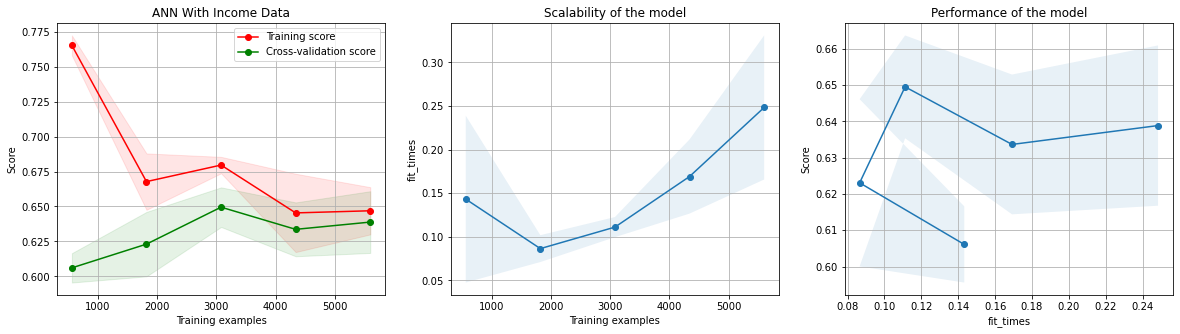

4.250924110412598


In [608]:
start = time.time()

make_learning_curve(MLPClassifier(random_state=42,
    max_iter=2000, activation='tanh', hidden_layer_sizes=1,solver= 'adam',learning_rate_init = 0.05
            ), X_Train_Income, Y_Train_Income, "ANN With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

In [564]:
# This one is only for the Polling Data 
def make_GridSearchCV_ANN4(X_Train, Y_Train):
    
    activations = ['identity']

    solvers = ['adam']
    hidden_layers = list(np.arange(150, 175, 2))
    
    init_learning_rates = [0.01, 0.05]
    param_grid = {'activation': activations, 'solver': solvers, 'hidden_layer_sizes': hidden_layers,'learning_rate_init': init_learning_rates}

    classifier = GridSearchCV(MLPClassifier(max_iter=2000,random_state=42),
                       param_grid=param_grid, 
                       scoring='f1',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [558]:
from sklearn.model_selection import GridSearchCV 

def make_GridSearchCV_ANN3(X_Train, Y_Train):
    
    activations = ['relu', 'identity','logistic','tanh']

    solvers = ['adam']
    hidden_layers = list(np.arange(1, 21, 2))
    
    init_learning_rates = [0.001, 0.01, 0.05, 0.10]
    param_grid = {'activation': activations, 'solver': solvers, 'hidden_layer_sizes': hidden_layers,'learning_rate_init': init_learning_rates}

    classifier = GridSearchCV(MLPClassifier(max_iter=2000,random_state=42),
                       param_grid=param_grid, 
                       scoring='f1',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [559]:
from sklearn.model_selection import GridSearchCV 

def make_GridSearchCV_ANN2(X_Train, Y_Train):
    
    activations = ['relu', 'identity','logistic','tanh']
    solvers = ['adam']
    init_learning_rates = [0.001, 0.01, 0.05, 0.10]
    param_grid = {'activation': activations, 'solver': solvers, 'learning_rate_init': init_learning_rates}

    classifier = GridSearchCV(MLPClassifier(max_iter=2000,random_state=42),
                       param_grid=param_grid, 
                       scoring='f1',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [560]:
from sklearn.model_selection import GridSearchCV 

def make_GridSearchCV_ANN(X_Train, Y_Train):
    
    activations = ['relu', 'identity','logistic','tanh']
    solvers = ['adam']
    hidden_layers = list(np.arange(1, 21, 2))

    param_grid = {'activation': activations, 'solver': solvers, 'hidden_layer_sizes': hidden_layers}

    classifier = GridSearchCV(MLPClassifier(max_iter=2000,random_state=42),
                       param_grid=param_grid, 
                       scoring='f1',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [189]:
start = time.time()

make_GridSearchCV_ANN(X_Train_Demographics_10k, Y_Train_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)


0.9247182034904036
{'activation': 'relu', 'hidden_layer_sizes': 1, 'solver': 'adam'}
1548.3728358745575


In [273]:
start = time.time()

make_GridSearchCV_ANN2(X_Train_Demographics_10k, Y_Train_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)


0.9247482048496719
{'activation': 'identity', 'learning_rate_init': 0.01, 'solver': 'adam'}
274.6301839351654


In [275]:
start = time.time()

make_GridSearchCV_ANN3(X_Train_Demographics_10k, Y_Train_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)


/Users/amandahutter/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.9260706810781038
{'activation': 'identity', 'hidden_layer_sizes': 7, 'learning_rate_init': 0.05, 'solver': 'adam'}
3223.4889299869537


In [562]:
start = time.time()

make_GridSearchCV_ANN4(X_Train_Demographics_10k, Y_Train_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)


0.9253068434343927
{'activation': 'identity', 'hidden_layer_sizes': 156, 'learning_rate_init': 0.01, 'solver': 'adam'}
73.48047375679016


In [190]:
start = time.time()

make_GridSearchCV_ANN(X_Train_Income, Y_Train_Income)

end = time.time()
elapsed = end - start
print(elapsed)


0.638865354977173
{'activation': 'logistic', 'hidden_layer_sizes': 1, 'solver': 'adam'}
655.8114178180695


In [272]:
start = time.time()

make_GridSearchCV_ANN2(X_Train_Income, Y_Train_Income)

end = time.time()
elapsed = end - start
print(elapsed)


0.6198038245361446
{'activation': 'identity', 'learning_rate_init': 0.01, 'solver': 'adam'}
337.6282801628113


In [276]:
start = time.time()

make_GridSearchCV_ANN3(X_Train_Income, Y_Train_Income)

end = time.time()
elapsed = end - start
print(elapsed)


0.6424599100840306
{'activation': 'tanh', 'hidden_layer_sizes': 1, 'learning_rate_init': 0.05, 'solver': 'adam'}
1274.7587897777557


In [499]:
def ann_init_learning_rate(X_Train, X_Test, Y_Train, Y_Test, activation, solver, hidden_layer, datasetname):
    
    init_learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.10]
    f1_scores_test = []
    f1_scores_train = []
    
    for rate in init_learning_rates:
        classifier = MLPClassifier(random_state=42,
                                   learning_rate_init = rate, 
                                   hidden_layer_sizes = (hidden_layer,),
                                   activation = activation, solver=solver,max_iter=1000)
        classifier.fit(X_Train, Y_Train)

        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_test.append(f1_score)

        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_train.append(f1_score)

    plt.plot(init_learning_rates, f1_scores_test, label = "Test")
    plt.plot(init_learning_rates, f1_scores_train, label = "Train")
    plt.xlabel("Init Learning Rate")
    plt.ylabel("F1 Score")
    plt.title(datasetname + "\n" + activation + " activation \n" + solver +" solver")
    plt.legend()
    plt.show()

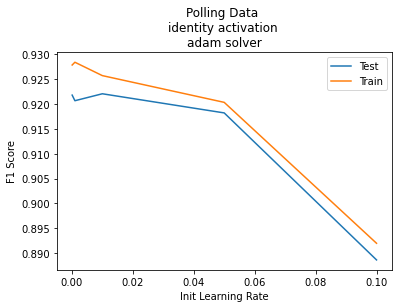

5.706712007522583


In [624]:
start = time.time()

ann_init_learning_rate(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 'identity', 'adam',156, "Polling Data ")

end = time.time()
elapsed = end-start
print(elapsed)

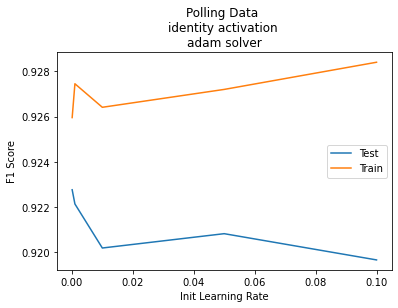

7.406542062759399


In [501]:
start = time.time()

ann_init_learning_rate(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 'identity', 'adam',1, "Polling Data ")

end = time.time()
elapsed = end-start
print(elapsed)


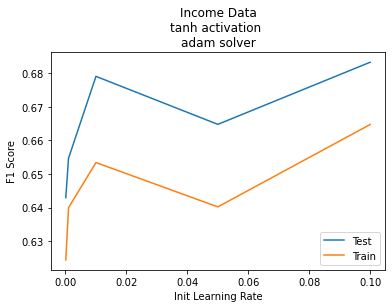

7.551904916763306


In [502]:
start = time.time()

ann_init_learning_rate(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, 'tanh', 'adam', 1, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

In [609]:
def ann_layers(X_Train, X_Test, Y_Train, Y_Test, activation, solver, datasetname):
    
    hidden_layers = list(np.arange(1,200,5))
    f1_scores_test = []
    f1_scores_train = []
    
    for num in hidden_layers:
        classifier = MLPClassifier((num,), activation, solver,max_iter=2000)
        classifier.fit(X_Train, Y_Train)

        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_test.append(f1_score)

        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_train.append(f1_score)

    plt.plot(hidden_layers, f1_scores_test,label = "Test")
    plt.plot(hidden_layers, f1_scores_train, label = "Train")
    plt.xlabel("Hidden Layer Sizes")
    plt.ylabel("F1 Score")
    plt.title(datasetname + "\n" + activation + " activation \n" + solver +" solver")
    plt.legend()
    plt.show()

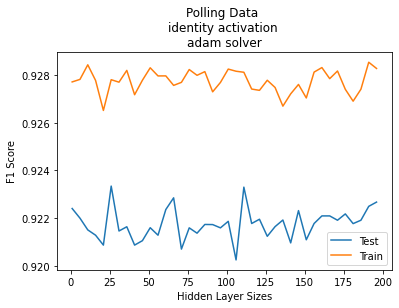

32.404029846191406


In [610]:
start = time.time() 

ann_layers(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 'identity','adam',"Polling Data ")

end = time.time()
lapsed = end - start
print(lapsed)

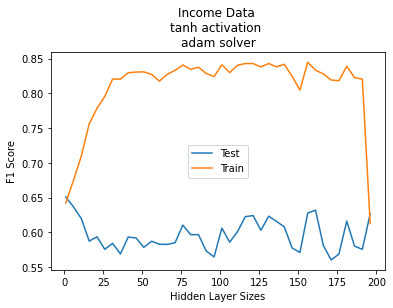

628.6182897090912


In [611]:
start = time.time()
ann_layers(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, 'tanh','adam',"Income Data ")
end = time.time()
elapsed = end-start
print(elapsed)

In [196]:
from sklearn.neural_network import MLPClassifier

def make_ann(hidden_layers, activation, solver ,group, X_Train, X_Test, Y_Train, Y_Test):
     
    classifier = MLPClassifier(hidden_layer_sizes=(hidden_layers,), solver=solver,activation=activation,max_iter=2000,random_state=42)
    classifier.fit(X_Train, Y_Train)
    
    if group == "TEST":
        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        
    else:
        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    f1_score = (2*tp) / (2*tp + fp + fn)
    precision_1 = tp / (tp + fp)
    precision_0 = tn / (tn + fn)
    recall_1 =  tp / (tp + fn)
    recall_0 =  tn / (tn + fp)
    return(accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn)
    

In [197]:
def make_ann_experiments(X_Train, X_Test, Y_Train, Y_Test):
 
    accuracy_list = []
    f1_list = []
    precision_1_list = []
    precision_0_list = []
    recall_1_list = []
    recall_0_list = []
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []

    #activation = ['relu', 'identity','logistic','tanh']
    activation = ['relu','logistic']
    #solver = ['adam', 'lbfgs','sgd']
    solver = ['adam']
    hidden_layers = list(np.arange(1, 21, 1))
    groups = ['TEST','TRAIN']

    a_list = []
    s_list = []
    h_list = []
    group_list = []

    for a in activation:
        for s in solver:
            for h in hidden_layers:         
                for group in groups:

                    accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn = make_ann(h, a, s, group, X_Train, X_Test, Y_Train, Y_Test)

                    accuracy_list.append(accuracy)
                    f1_list.append(f1_score)
                    precision_1_list.append(precision_1)
                    precision_0_list.append(precision_0)
                    recall_1_list.append(recall_1)
                    recall_0_list.append(recall_0)
                    a_list.append(a)
                    s_list.append(s)
                    h_list.append(h)
                    group_list.append(group)
                    tp_list.append(tp)
                    tn_list.append(tn)
                    fp_list.append(fp)
                    fn_list.append(fn)

    results_ann = pd.DataFrame(zip(a_list, s_list, h_list, group_list, accuracy_list, f1_list, precision_1_list,precision_0_list,recall_1_list,recall_0_list, tp_list, tn_list, fp_list, fn_list), 
                            columns = ["Activation", 'Solver','Hidden_Layers', "Test_Group",'Accuracy','F1_Score','Precision_1','Precision_0','Recall_1','Recall_0', 'TP', 'TN', 'FP', 'FN'])
    return(results_ann)

start = time.time()

ANN_Votes =  make_ann_experiments(X_Train_Votes, X_Test_Votes, Y_Train_Votes, Y_Test_Votes)

end = time.time()
elapsed = end - start
print(elapsed)

ANN_Votes.head()

In [198]:
start = time.time()

ANN_Demographics_10k = make_ann_experiments(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)

/Users/amandahutter/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amandahutter/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amandahutter/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/amandahutter/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached an

694.1935479640961


/Users/amandahutter/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [199]:
ANN_Demographics_10k.head()

,Activation,Solver,Hidden_Layers,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
0,relu,adam,1,TEST,0.914667,0.925451,0.919560,0.908019,0.931419,0.892581,1589,1155,139,117
1,relu,adam,1,TRAIN,0.917000,0.926927,0.926112,0.904998,0.927744,0.902906,3685,2734,294,287
2,relu,adam,2,TEST,0.912667,0.923926,0.915420,0.908875,0.932591,0.886399,1591,1147,147,115
3,relu,adam,2,TRAIN,0.917286,0.927197,0.926149,0.905598,0.928248,0.902906,3687,2734,294,285
4,relu,adam,3,TEST,0.908667,0.919883,0.917736,0.896579,0.922040,0.891036,1573,1153,141,133


In [202]:
start = time.time()

ANN_Income =  make_ann_experiments(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income)

end = time.time()
elapsed = end - start
print(elapsed)

563.5334460735321


In [203]:
ANN_Income.head()

,Activation,Solver,Hidden_Layers,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
0,relu,adam,1,TEST,0.837000,0.633708,0.701493,0.871089,0.577869,0.920635,423,2088,180,309
1,relu,adam,1,TRAIN,0.836429,0.622237,0.690842,0.871695,0.566026,0.920885,943,4912,422,723
2,relu,adam,2,TEST,0.841000,0.647450,0.705314,0.876419,0.598361,0.919312,438,2085,183,294
3,relu,adam,2,TRAIN,0.834571,0.617063,0.687040,0.870082,0.560024,0.920322,933,4909,425,733
4,relu,adam,3,TEST,0.837000,0.643326,0.690141,0.876747,0.602459,0.912698,441,2070,198,291


#### 3) Boosted Decision Tree

[0.90768664 0.91880168 0.92358447 0.92175266 0.92302272]


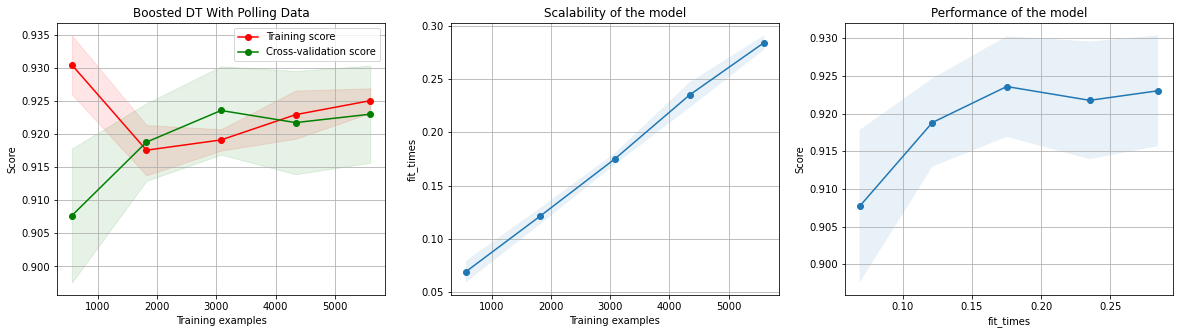

5.9613471031188965


In [612]:
start = time.time()

make_learning_curve(AdaBoostClassifier(random_state=42), X_Train_Demographics_10k, Y_Train_Demographics_10k, "Boosted DT With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.91358826 0.91996075 0.92376543 0.92371762 0.924547  ]


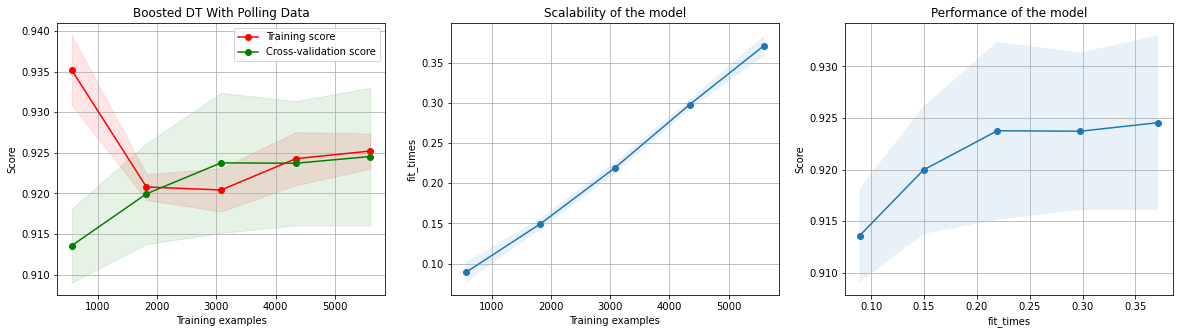

7.410023927688599


In [613]:
start = time.time()

make_learning_curve(AdaBoostClassifier(algorithm='SAMME.R',learning_rate=0.6,n_estimators=65,random_state=42),
                    X_Train_Demographics_10k, Y_Train_Demographics_10k, "Boosted DT With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.56933569 0.5903256  0.60152451 0.60673297 0.59867567]


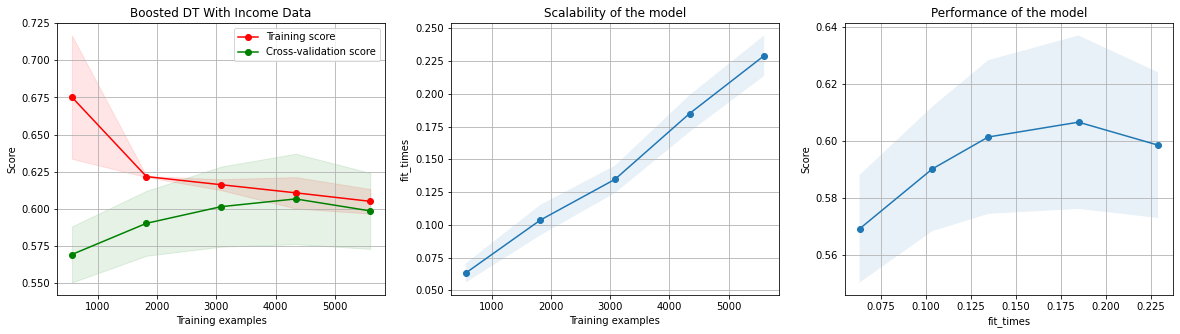

5.010721921920776


In [614]:
start = time.time()

make_learning_curve(AdaBoostClassifier(random_state=42), X_Train_Income, Y_Train_Income, "Boosted DT With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.57088793 0.59153461 0.59591833 0.60214037 0.59803781]


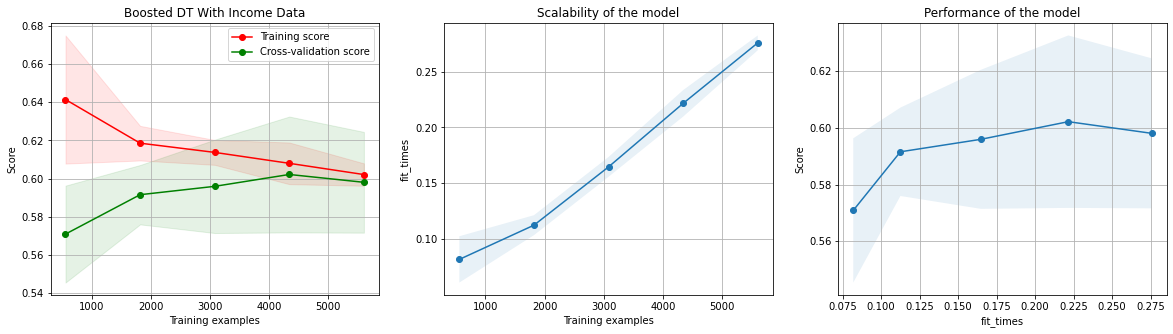

5.7416040897369385


In [615]:
start = time.time()

make_learning_curve(AdaBoostClassifier(algorithm='SAMME.R', learning_rate=0.8, n_estimators=60,random_state=42),
                    X_Train_Income, Y_Train_Income, "Boosted DT With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

In [390]:
from sklearn.model_selection import GridSearchCV 

def make_GridSearchCV_Boosted_DT(X_Train, Y_Train):
    
    #algorithms = ['SAMME', 'SAMME.R']
    algorithms = ['SAMME.R']

    learning_rates = np.arange(0.5,1,step=0.10)
    num_est = np.arange(10,100,step=5)

    param_grid = {'algorithm': algorithms, 'learning_rate': learning_rates, 'n_estimators': num_est}

    classifier = GridSearchCV(AdaBoostClassifier(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'f1',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [212]:
start = time.time()

make_GridSearchCV_Boosted_DT(X_Train_Demographics_10k, Y_Train_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)

0.9245469953793887
{'algorithm': 'SAMME.R', 'learning_rate': 0.6, 'n_estimators': 65}
9297.502034902573


In [391]:
start = time.time()

make_GridSearchCV_Boosted_DT(X_Train_Demographics_10k, Y_Train_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)

0.9245469953793887
{'algorithm': 'SAMME.R', 'learning_rate': 0.6, 'n_estimators': 65}
259.9324240684509


In [213]:
start = time.time()
make_GridSearchCV_Boosted_DT(X_Train_Income, Y_Train_Income)

end = time.time()
elapsed = end - start
print(elapsed)

0.5980378126445337
{'algorithm': 'SAMME.R', 'learning_rate': 0.7999999999999999, 'n_estimators': 60}
17503.1936981678


In [392]:
start = time.time()
make_GridSearchCV_Boosted_DT(X_Train_Income, Y_Train_Income)

end = time.time()
elapsed = end - start
print(elapsed)

0.5980378126445337
{'algorithm': 'SAMME.R', 'learning_rate': 0.7999999999999999, 'n_estimators': 60}
172.48895907402039


In [492]:
def learning_rate(X_Train, X_Test, Y_Train, Y_Test, datasetname):
    
    f1_scores_test = []
    f1_scores_train = []
    learning_rates = np.arange(.1,1.1,0.10)
    
    for l in learning_rates:
        classifier = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate = l, random_state=42)
        classifier.fit(X_Train, Y_Train)
        Y_Pred = classifier.predict(X_Test)
        
        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_test.append(f1_score)

        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_train.append(f1_score)

    plt.plot(learning_rates, f1_scores_test,label = "Test")
    plt.plot(learning_rates, f1_scores_train, label = "Train")
    plt.xlabel("Learning Rate")
    plt.ylabel("F1 Score")
    plt.title(datasetname + "\n" +  "SAMME.R Algorithm")
    plt.legend()
    plt.show()
        

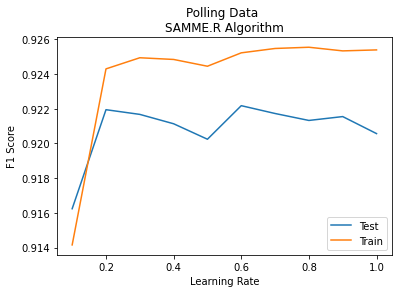

6.594419956207275


In [493]:
start = time.time()
learning_rate(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, "Polling Data ")
end=time.time()
elapsed = end-start
print(elapsed)

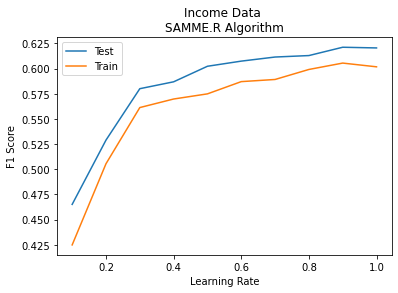

5.16133189201355


In [494]:
start = time.time()
learning_rate(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, "Income Data ")
end=time.time()
elapsed = end-start
print(elapsed)

In [489]:
def num_est(X_Train, X_Test, Y_Train, Y_Test, datasetname):
    
    f1_scores_test = []
    f1_scores_train = []
    num_estimators = np.arange(10, 100, 10)
    
    for num in num_estimators:
        classifier = AdaBoostClassifier(algorithm = 'SAMME.R', n_estimators = num, random_state = 42)
        classifier.fit(X_Train, Y_Train)
        Y_Pred = classifier.predict(X_Test)
        
        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_test.append(f1_score)

        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_train.append(f1_score)

    plt.plot(num_estimators, f1_scores_test,label = "Test")
    plt.plot(num_estimators, f1_scores_train, label = "Train")
    plt.xlabel("Number of Estimators")
    plt.ylabel("F1 Score")
    plt.title(datasetname + "\n" + "SAMME.R Algorithm")
    plt.legend()
    plt.show()
        

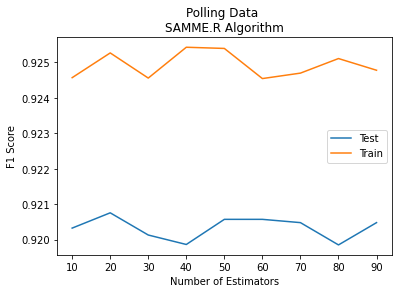

5.794582843780518


In [490]:
start = time.time()

num_est(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, "Polling Data ")

end=time.time()
elapsed = end-start
print(elapsed)

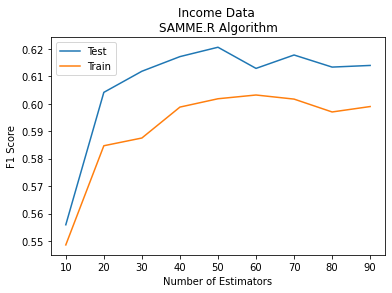

4.572304010391235


In [491]:
start = time.time()

num_est(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, "Income Data ")

end=time.time()
elapsed = end-start
print(elapsed)

In [399]:

def make_boosted_dt(algo, l , n_est, group, X_Train, X_Test, Y_Train, Y_Test):

    classifier = AdaBoostClassifier(algorithm = algo, learning_rate = l, n_estimators=n_est, random_state=42)
    classifier.fit(X_Train, Y_Train)

    Y_Pred = classifier.predict(X_Test)
    
    if group == "TEST":
        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()    
    else:
        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    f1_score = (2*tp) / (2*tp + fp + fn)
    precision_1 = tp / (tp + fp)
    precision_0 = tn / (tn + fn)
    recall_1 =  tp / (tp + fn)
    recall_0 =  tn / (tn + fp)
    return(accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn)


In [215]:
def make_boosted_dt_experiments(X_Train, X_Test, Y_Train, Y_Test):
    
    accuracy_list = []
    f1_list = []
    precision_1_list = []
    precision_0_list = []
    recall_1_list = []
    recall_0_list = []
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []

    algo = ['SAMME', 'SAMME.R']
    learn_rate = np.arange(0.5,1,step=0.10)
    num_est = np.arange(1,100,step=5)
    groups = ['TEST','TRAIN']

    a_list = []
    l_list = []
    n_list = []
    group_list = []

    for a in algo:
        for l in learn_rate:
            for n in num_est:
                for group in groups:

                    accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn  = make_boosted_dt(a, l, n, group, X_Train, X_Test, Y_Train, Y_Test)
                  
                    accuracy_list.append(accuracy)
                    f1_list.append(f1_score)
                    precision_1_list.append(precision_1)
                    precision_0_list.append(precision_0)
                    recall_1_list.append(recall_1)
                    recall_0_list.append(recall_0)
                    a_list.append(a)
                    l_list.append(l)
                    n_list.append(n)
                    group_list.append(group)
                    tp_list.append(tp)
                    tn_list.append(tn)
                    fp_list.append(fp)
                    fn_list.append(fn)

    results_boosted_dt = pd.DataFrame(zip(a_list,l_list,n_list, group_list, accuracy_list, f1_list, precision_1_list,precision_0_list,recall_1_list,recall_0_list, tp_list, tn_list, fp_list, fn_list), 
                            columns = ['Algorithm','Learning_Rate','Num_Estimators', "Test_Group",'Accuracy','F1_Score','Precision_1','Precision_0','Recall_1','Recall_0', 'TP', 'TN', 'FP', 'FN'])
    
    return(results_boosted_dt)

In [400]:
start = time.time()

Boosted_DT_Demographics_10k = make_boosted_dt_experiments(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)

264.8652470111847


In [401]:
Boosted_DT_Demographics_10k.head()

,Algorithm,Learning_Rate,Num_Estimators,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
0,SAMME,0.5,1,TEST,0.890333,0.898300,0.950294,0.828008,0.851700,0.941267,1453,1218,76,253
1,SAMME,0.5,1,TRAIN,0.887143,0.894667,0.950964,0.822293,0.844663,0.942867,3355,2855,173,617
2,SAMME,0.5,6,TEST,0.890333,0.898300,0.950294,0.828008,0.851700,0.941267,1453,1218,76,253
3,SAMME,0.5,6,TRAIN,0.887143,0.894667,0.950964,0.822293,0.844663,0.942867,3355,2855,173,617
4,SAMME,0.5,11,TEST,0.906333,0.915029,0.945034,0.862044,0.886870,0.931994,1513,1206,88,193


In [402]:
start = time.time() 

Boosted_DT_Income =  make_boosted_dt_experiments(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income)

end = time.time()
elapsed = end - start
print(elapsed)

/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/Users

174.2359230518341


In [403]:
Boosted_DT_Income.head()

,Algorithm,Learning_Rate,Num_Estimators,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
0,SAMME,0.5,1,TEST,0.756000,0.000000,NaN,0.756000,0.000000,1.000000,0,2268,0,732
1,SAMME,0.5,1,TRAIN,0.762000,0.000000,NaN,0.762000,0.000000,1.000000,0,5334,0,1666
2,SAMME,0.5,6,TEST,0.797667,0.491199,0.635575,0.827097,0.400273,0.925926,293,2100,168,439
3,SAMME,0.5,6,TRAIN,0.784857,0.440565,0.577973,0.820388,0.355942,0.918823,593,4901,433,1073
4,SAMME,0.5,11,TEST,0.797667,0.491199,0.635575,0.827097,0.400273,0.925926,293,2100,168,439


#### 4) SVM

[0.92266901 0.92416363 0.9226053  0.92263743 0.92290917]


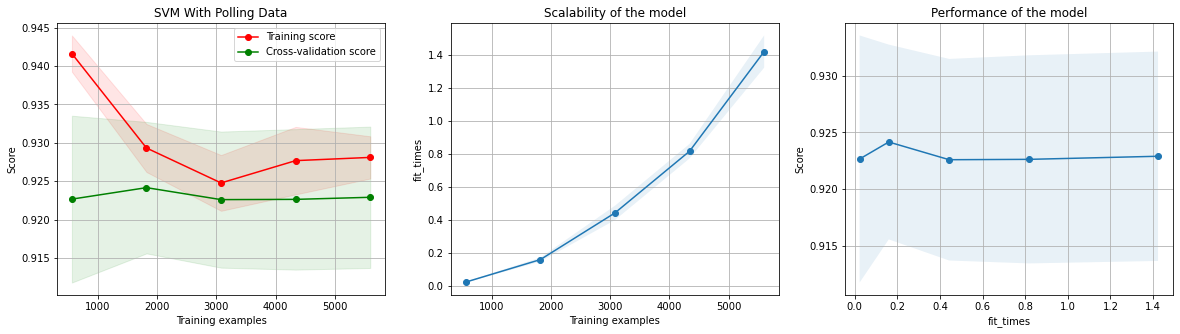

29.015024185180664


In [616]:
start = time.time()

make_learning_curve(SVC(random_state=42), X_Train_Demographics_10k, Y_Train_Demographics_10k, "SVM With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.91800599 0.92185615 0.92346706 0.92336372 0.92307066]


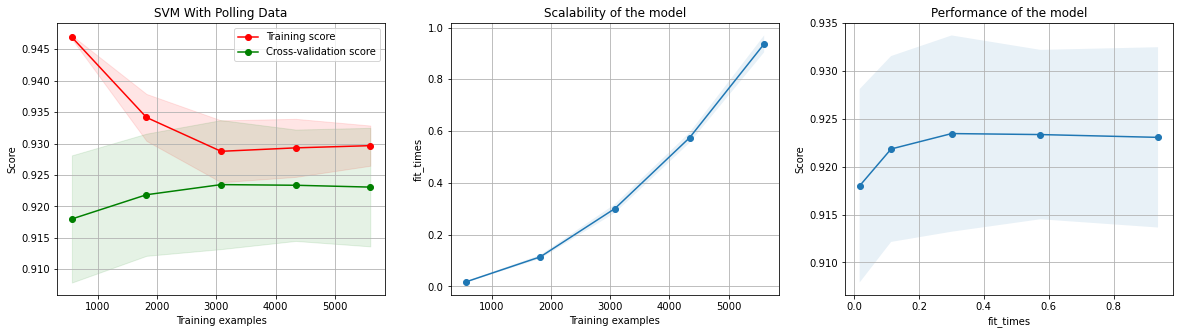

19.479631185531616


In [617]:
start = time.time()

make_learning_curve(SVC(random_state=42,
                       C=1, kernel='poly', degree=2
                       ), X_Train_Demographics_10k, Y_Train_Demographics_10k, "SVM With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.52885446 0.58444989 0.58813664 0.59421041 0.59096994]


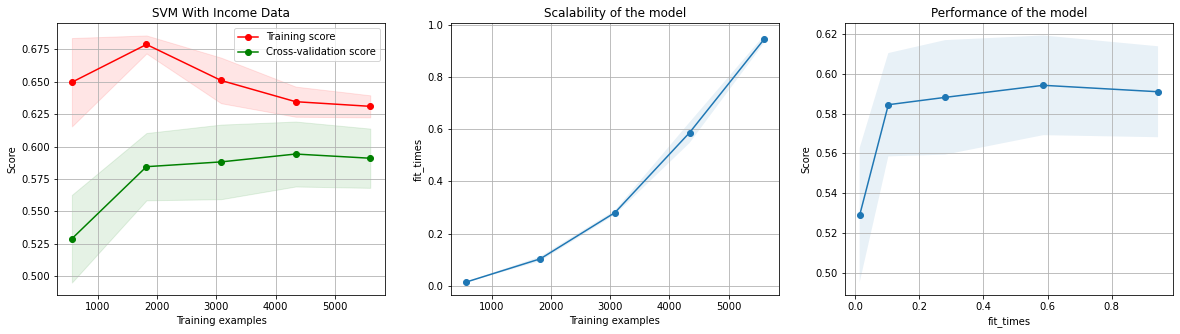

20.79584503173828


In [618]:
start = time.time()

make_learning_curve(SVC(random_state=42), X_Train_Income, Y_Train_Income, "SVM With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

[0.57478921 0.61287648 0.61382353 0.60431076 0.60017648]


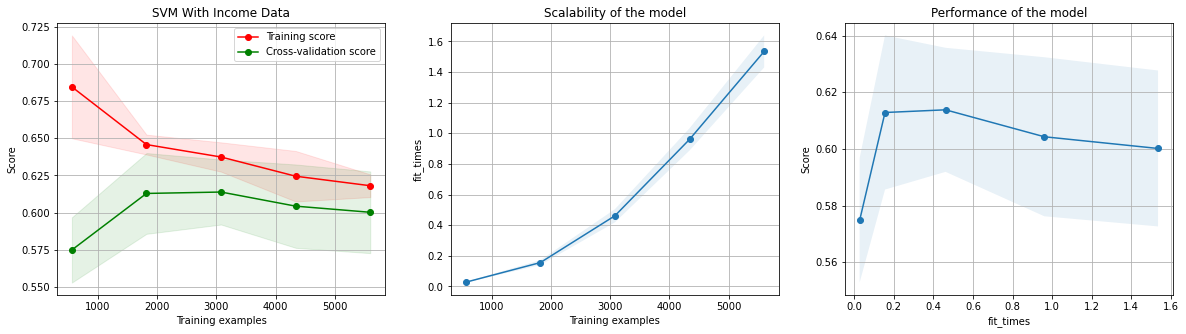

23.60265612602234


In [619]:
start = time.time()

make_learning_curve(SVC(random_state=42,
                       C = 10, kernel = 'linear'
                       ), X_Train_Income, Y_Train_Income, "SVM With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

In [406]:
from sklearn.model_selection import GridSearchCV 

def make_GridSearchCV_SVM(X_Train, Y_Train):
    
    cs = [1,10]
    kernels = ['linear','rbf', 'poly']
    degrees = [2, 3, 4]
    
    param_grid = {'C': cs, 'kernel': kernels, 'degree': degrees}

    classifier = GridSearchCV(SVC(random_state=42),
                       param_grid=param_grid, 
                       scoring = 'f1',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [407]:
start = time.time()

make_GridSearchCV_SVM(X_Train_Demographics_10k, Y_Train_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)

0.923070656951418
{'C': 1, 'degree': 2, 'kernel': 'poly'}
1584.623838186264


In [408]:
start = time.time()

make_GridSearchCV_SVM(X_Train_Income, Y_Train_Income)

end = time.time()
elapsed = end - start
print(elapsed)

0.6001764753092969
{'C': 10, 'degree': 2, 'kernel': 'linear'}
3729.4521498680115


In [575]:
def gamma(X_Train, X_Test, Y_Train, Y_Test, c, kernel, degree, datasetname):

    f1_scores_test = []
    f1_scores_train = []
    gammas = [0.10, 1, 10, 100]
 
    for gamma in gammas:
        
        classifier = SVC(C = c, kernel = kernel, degree = degree, random_state = 42, gamma = gamma)
        classifier.fit(X_Train, Y_Train)
        Y_Pred = classifier.predict(X_Test)

        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_test.append(f1_score)

        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_train.append(f1_score)

    plt.plot(gammas, f1_scores_test,label = "Test")
    plt.plot(gammas, f1_scores_train, label = "Train")
    plt.xlabel("Gamma")
    plt.ylabel("F1 Score")
    plt.title(datasetname + "\n" + str(c) + " C Regularization \n" + kernel + " kernel")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.legend()
    plt.show()
    

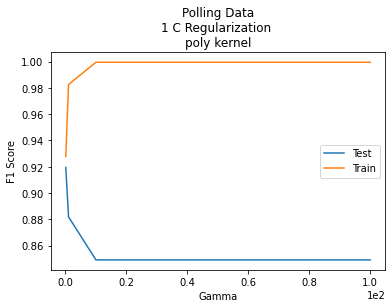

43.5465042591095


In [576]:
start = time.time()

gamma(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 1, 'poly', 2, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

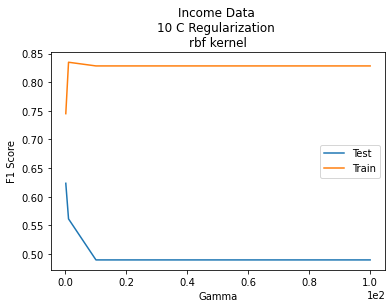

25.70598602294922


In [578]:
start = time.time()

gamma(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, 10, 'rbf', 3, "Income Data ")

end = time.time()
elapsed = end-start
print(elapsed)

In [480]:
def kernel(X_Train, X_Test, Y_Train, Y_Test, c, datasetname):
   
    f1_scores_test = []
    f1_scores_train = []
    kernels = ['sigmoid','linear','rbf','poly']
    degrees = [2, 3, 4, 5, 6]
    kernel_list =  ['sigmoid','linear', 'rbf', 'poly2', 'poly3', 'poly4', 'poly5', 'poly6']
    
    for kernel in kernels:
        if kernel == 'poly':
            for degree in degrees:
                classifier = SVC(C = c, kernel = kernel, degree = degree, random_state = 42)
                classifier.fit(X_Train, Y_Train)
                Y_Pred = classifier.predict(X_Test)

                Y_Pred = classifier.predict(X_Test)
                cm = confusion_matrix(Y_Test, Y_Pred)
                tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
                f1_score = (2*tp) / (2*tp + fp + fn)
                f1_scores_test.append(f1_score)

                Y_Pred = classifier.predict(X_Train)
                cm = confusion_matrix(Y_Train, Y_Pred)
                tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
                f1_score = (2*tp) / (2*tp + fp + fn)
                f1_scores_train.append(f1_score)
            
        else:
            classifier = SVC(C = c, kernel = kernel,random_state = 42)
            classifier.fit(X_Train, Y_Train)
            Y_Pred = classifier.predict(X_Test)
        
            Y_Pred = classifier.predict(X_Test)
            cm = confusion_matrix(Y_Test, Y_Pred)
            tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
            f1_score = (2*tp) / (2*tp + fp + fn)
            f1_scores_test.append(f1_score)

            Y_Pred = classifier.predict(X_Train)
            cm = confusion_matrix(Y_Train, Y_Pred)
            tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
            f1_score = (2*tp) / (2*tp + fp + fn)
            f1_scores_train.append(f1_score)

    plt.plot(kernel_list, f1_scores_test,label = "Test")
    plt.plot(kernel_list, f1_scores_train, label = "Train")
    plt.xlabel("Learning Rate")
    plt.ylabel("F1 Score")
    plt.title(datasetname + "\n" + str(c) + " C Regularization")
    plt.legend()
    plt.show()

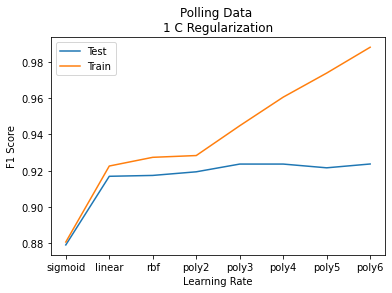

38.00609302520752


In [481]:
start = time.time()

kernel(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 1, "Polling Data ")

end = time.time()
elapsed = end-start
print(elapsed)

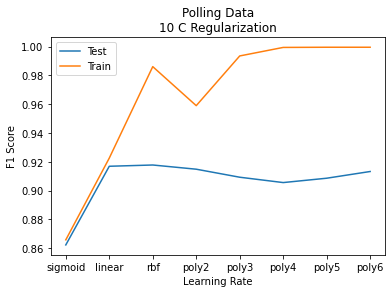

42.103063106536865


In [482]:
start = time.time()

kernel(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 10, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

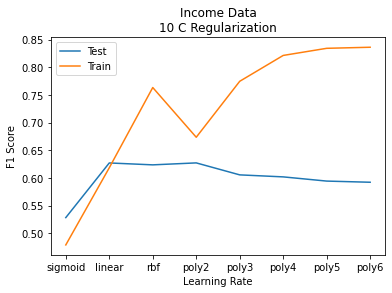

29.67920994758606


In [483]:
start = time.time()

kernel(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, 10, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

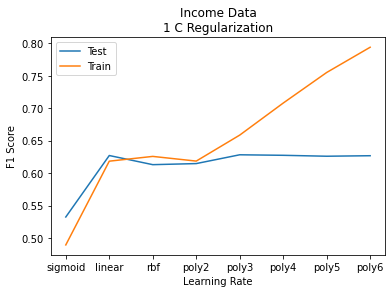

26.52688217163086


In [484]:
start = time.time()

kernel(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, 1, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

In [463]:
# Fit SVM Classifier to the training data set  
#from sklearn.svm import SVC

def make_svm(kernel, c , degree, group, X_Train, X_Test, Y_Train, Y_Test):

    classifier = SVC(C = c, kernel = kernel, degree = degree, random_state=42)
    classifier.fit(X_Train, Y_Train)

    # Predict the DV Test set using the classifer 
    Y_Pred = classifier.predict(X_Test)

    if group == "TEST":
        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()    
    else:
        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    f1_score = (2*tp) / (2*tp + fp + fn)
    precision_1 = tp / (tp + fp)
    precision_0 = tn / (tn + fn)
    recall_1 =  tp / (tp + fn)
    recall_0 =  tn / (tn + fp)
    return(accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn)



In [410]:

def make_svm_experiments(X_Train, X_Test, Y_Train, Y_Test):
    
    accuracy_list = []
    f1_list = []
    precision_1_list = []
    precision_0_list = []
    recall_1_list = []
    recall_0_list = []
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []

    kernels = ['linear','rbf','sigmoid','poly']
    degrees = np.arange(1,5,step=1)
    cs = [1,10]
    groups = ['TEST','TRAIN']

    k_list = []
    d_list = []
    c_list = []
    group_list = []

    for k in kernels:
        for d in degrees:
            for c in cs:
                for group in groups:

                    accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn  = make_svm(k, d, c, group, X_Train, X_Test, Y_Train, Y_Test)

                    accuracy_list.append(accuracy)
                    f1_list.append(f1_score)
                    precision_1_list.append(precision_1)
                    precision_0_list.append(precision_0)
                    recall_1_list.append(recall_1)
                    recall_0_list.append(recall_0)
                    k_list.append(k)
                    d_list.append(d)
                    c_list.append(c)
                    group_list.append(group)
                    tp_list.append(tp)
                    tn_list.append(tn)
                    fp_list.append(fp)
                    fn_list.append(fn)

    results_svm = pd.DataFrame(zip(k_list, d_list, c_list, group_list, accuracy_list, f1_list, precision_1_list,precision_0_list,recall_1_list,recall_0_list, tp_list, tn_list, fp_list, fn_list), 
                            columns = ['Kernels', "Degree", "C", "Test_Group",'Accuracy','F1_Score','Precision_1','Precision_0','Recall_1','Recall_0', 'TP', 'TN', 'FP', 'FN'])
    
    
    return(results_svm)

start = time.time()

SVM_Demographics_10k = make_svm_experiments(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)

In [411]:
SVM_Demographics_10k.head()

,Kernels,Degree,C,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
0,linear,1,1,TEST,0.904000,0.916907,0.902841,0.905645,0.931419,0.867852,1589,1123,171,117
1,linear,1,1,TRAIN,0.911143,0.922579,0.912358,0.909462,0.933031,0.882431,3706,2672,356,266
2,linear,1,10,TEST,0.904000,0.916907,0.902841,0.905645,0.931419,0.867852,1589,1123,171,117
3,linear,1,10,TRAIN,0.911143,0.922579,0.912358,0.909462,0.933031,0.882431,3706,2672,356,266
4,linear,2,1,TEST,0.904000,0.916907,0.902841,0.905645,0.931419,0.867852,1589,1123,171,117


start = time.time()

SVM_Income = make_svm_experiments(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income)

end = time.time()
elapsed = end - start
print(elapsed)

In [412]:
SVM_Income.head()

,Kernels,Degree,C,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
0,linear,1,1,TEST,0.836667,0.627093,0.707904,0.867659,0.562842,0.925044,412,2098,170,320
1,linear,1,1,TRAIN,0.837429,0.618377,0.700608,0.869106,0.553421,0.926134,922,4940,394,744
2,linear,1,10,TEST,0.836667,0.627093,0.707904,0.867659,0.562842,0.925044,412,2098,170,320
3,linear,1,10,TRAIN,0.837429,0.618377,0.700608,0.869106,0.553421,0.926134,922,4940,394,744
4,linear,2,1,TEST,0.836667,0.627093,0.707904,0.867659,0.562842,0.925044,412,2098,170,320




#### 5) KNN 

Polling Data - Default 

[0.89631237 0.90312421 0.90465378 0.90701541 0.90583206]


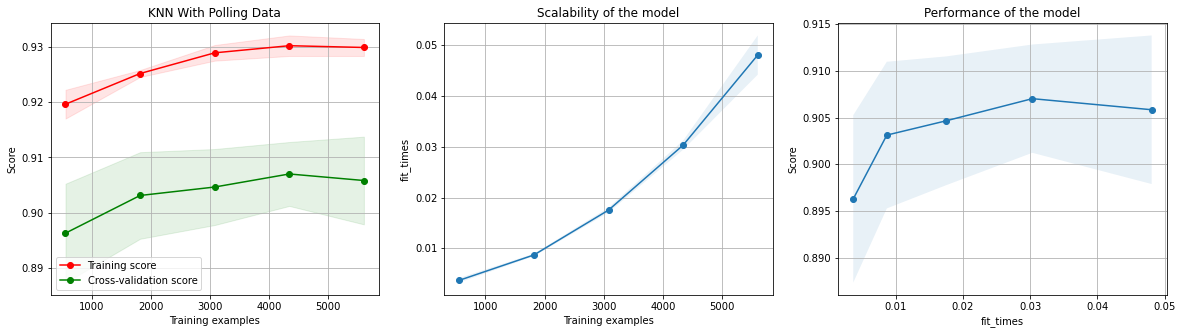

50.268994092941284


In [620]:
start = time.time()

make_learning_curve(KNeighborsClassifier(), X_Train_Demographics_10k, Y_Train_Demographics_10k, "KNN With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

Polling Data - Best

[0.90857814 0.91542823 0.91604087 0.91761732 0.9185421 ]


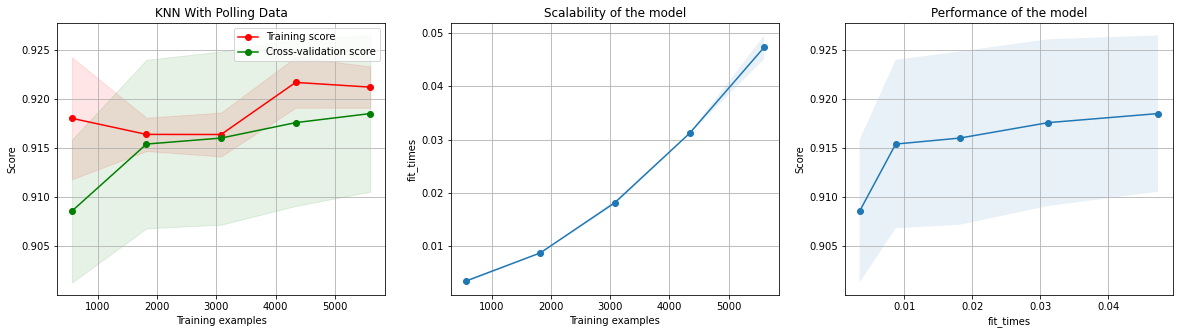

50.68199801445007


In [621]:
start = time.time()

make_learning_curve(KNeighborsClassifier(n_neighbors=35, p=1, weights='uniform'), X_Train_Demographics_10k, Y_Train_Demographics_10k, "KNN With Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

Income Data - Default 

[0.51548498 0.56380132 0.57111436 0.57660437 0.58969989]


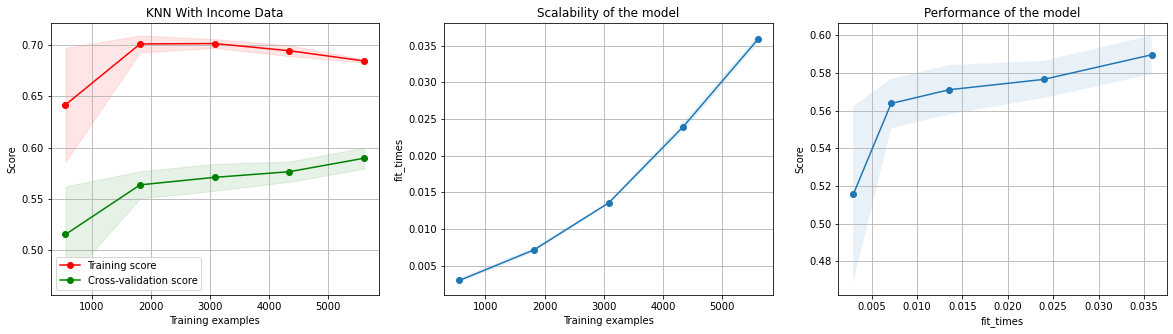

29.452283143997192


In [622]:
start = time.time()

make_learning_curve(KNeighborsClassifier(), X_Train_Income, Y_Train_Income, "KNN With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

Income Data - Best

[0.50563021 0.57462647 0.58225844 0.58555851 0.60199189]


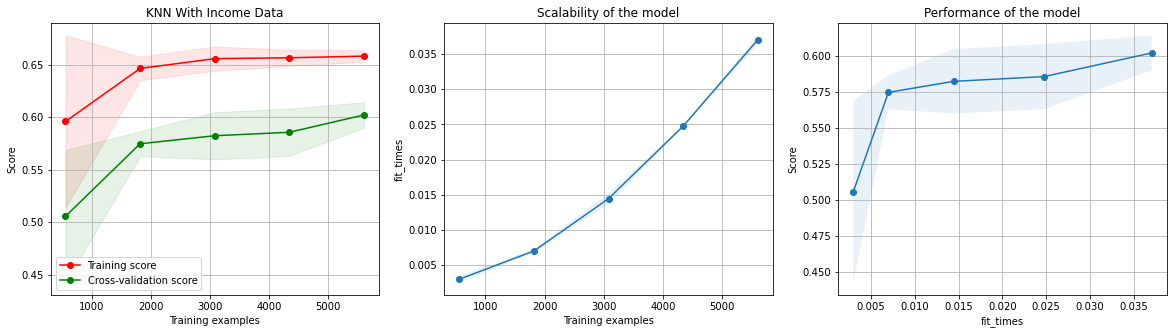

29.11258816719055


In [623]:
start = time.time()

make_learning_curve(KNeighborsClassifier(n_neighbors=11,p=1,weights='uniform'), X_Train_Income, Y_Train_Income, "KNN With Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

In [472]:
#from sklearn.model_selection import GridSearchCV 

def make_GridSearchCV_KNN(X_Train, Y_Train):
    
    ks = np.arange(1, 51, step = 2)
    ps = np.arange(1, 3, step = 1)

    weights = ['uniform', 'distance'] 
    
    param_grid = { 'n_neighbors': ks, 'weights': weights, 'p': ps}

    classifier = GridSearchCV(KNeighborsClassifier(),
                       param_grid=param_grid, 
                       scoring = 'f1',
                       cv=5)
    
    classifier =  classifier.fit(X_Train, Y_Train)
    print(classifier.best_score_)
    print(classifier.best_params_)
    


In [585]:
start = time.time()

make_GridSearchCV_KNN(X_Train_Demographics_10k, Y_Train_Demographics_10k)

end = time.time()
elapsed = end - start
print(elapsed)

0.9185420957422096
{'n_neighbors': 35, 'p': 1, 'weights': 'uniform'}
524.7837257385254


In [586]:
start = time.time()

make_GridSearchCV_KNN(X_Train_Income, Y_Train_Income)

end = time.time()
elapsed = end - start
print(elapsed)

0.6019918917678044
{'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
315.02977299690247


In [511]:

def nearest_neighbors(X_Train, X_Test, Y_Train, Y_Test, p, weights, datasetname):
    
    nearest_neighbors = list(np.arange(1,50,5))
    f1_scores_test = []
    f1_scores_train = []
    
    for k in nearest_neighbors:
        classifier = KNeighborsClassifier(n_neighbors = k,p = p, weights = weights)
        classifier.fit(X_Train, Y_Train)

        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_test.append(f1_score)

        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        f1_score = (2*tp) / (2*tp + fp + fn)
        f1_scores_train.append(f1_score)

    plt.plot(nearest_neighbors, f1_scores_test,label = "Test")
    plt.plot(nearest_neighbors, f1_scores_train, label = "Train")
    plt.xlabel("Nearest Neighbors")
    plt.ylabel("F1 Score")
    plt.title(datasetname + "\n"+ str(p) + " degree \n" + weights +" weights")
    plt.legend()
    plt.show()

0.6019918917678044
{'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
279.50816679000854


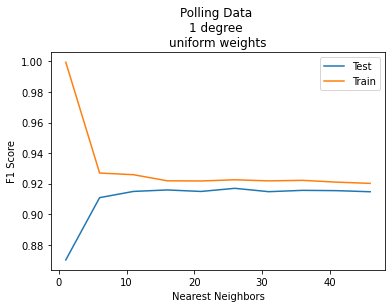

80.27100491523743


In [512]:
start = time.time()
nearest_neighbors(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k, 1, 'uniform',"Polling Data ")
    
end = time.time()
elapsed = end - start
print(elapsed)

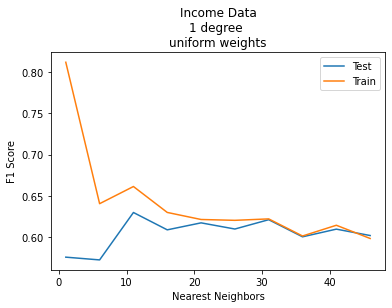

44.05749177932739


In [513]:
start = time.time()

nearest_neighbors(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income, 1, 'uniform', "Income Data")
    
end = time.time()
elapsed = end-start
print(elapsed)

In [249]:
# Fit KNN Classifier to the training data set  
from sklearn.neighbors import KNeighborsClassifier

def make_knn(k,metric,p,group, X_Train, X_Test, Y_Train, Y_Test):
     
    classifier = KNeighborsClassifier(n_neighbors = k, metric = metric, p = p)
    classifier.fit(X_Train, Y_Train)

    Y_Pred = classifier.predict(X_Test)
    
    if group == "TEST":
        Y_Pred = classifier.predict(X_Test)
        cm = confusion_matrix(Y_Test, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Pred).ravel()    
    else:
        Y_Pred = classifier.predict(X_Train)
        cm = confusion_matrix(Y_Train, Y_Pred)
        tn, fp, fn, tp = confusion_matrix(Y_Train, Y_Pred).ravel()
        
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    f1_score = (2*tp) / (2*tp + fp + fn)
    precision_1 = tp / (tp + fp)
    precision_0 = tn / (tn + fn)
    recall_1 =  tp / (tp + fn)
    recall_0 =  tn / (tn + fp)
    return(accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn)

In [250]:

def make_knn_experiments(X_Train, X_Test, Y_Train, Y_Test):
    
    accuracy_list = []
    f1_list = []
    precision_1_list = []
    precision_0_list = []
    recall_1_list = []
    recall_0_list = []
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []

    knns = np.arange(1, 25, step=2)
    metrics = ['minkowski']
    
    powers = [1]
    groups = ['TEST','TRAIN']

    k_list = []
    m_list = []
    p_list = []
    group_list = []


    for k in knns:
        for m in metrics:
            for p in powers:
                for group in groups:

                    #accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn  = make_knn(k=k,metric=m,p=p,group=group)
                    accuracy, f1_score, precision_1, precision_0, recall_1, recall_0, tp, tn, fp, fn  = make_knn(k, m, p, group, X_Train, X_Test, Y_Train, Y_Test)


                    accuracy_list.append(accuracy)
                    f1_list.append(f1_score)
                    precision_1_list.append(precision_1)
                    precision_0_list.append(precision_0)
                    recall_1_list.append(recall_1)
                    recall_0_list.append(recall_0)
                    k_list.append(k)
                    m_list.append(m)
                    p_list.append(p)
                    group_list.append(group)
                    tp_list.append(tp)
                    tn_list.append(tn)
                    fp_list.append(fp)
                    fn_list.append(fn)

    results_knn = pd.DataFrame(zip(k_list, m_list, p_list, group_list, accuracy_list, f1_list, precision_1_list,precision_0_list,recall_1_list,recall_0_list, tp_list, tn_list, fp_list, fn_list), 
                            columns = ['Neighbors', "Metric", "Power", "Test_Group",'Accuracy','F1_Score','Precision_1','Precision_0','Recall_1','Recall_0', 'TP', 'TN', 'FP', 'FN'])
    return(results_knn)

In [251]:
start = time.time()
KNN_Demographics_10k = make_knn_experiments(X_Train_Demographics_10k, X_Test_Demographics_10k, Y_Train_Demographics_10k, Y_Test_Demographics_10k)
end = time.time()
elapsed = end - start
print(elapsed)

167.48367595672607


In [252]:
KNN_Demographics_10k.head()

,Neighbors,Metric,Power,Test_Group,Accuracy,F1_Score,Precision_1,Precision_0,Recall_1,Recall_0,TP,TN,FP,FN
0,1,minkowski,1,TEST,0.850000,0.870017,0.857631,0.839228,0.882767,0.806801,1506,1044,250,200
1,1,minkowski,1,TRAIN,0.999429,0.999496,0.999496,0.999339,0.999496,0.999339,3970,3026,2,2
2,3,minkowski,1,TEST,0.883333,0.899135,0.884354,0.881877,0.914420,0.842349,1560,1090,204,146
3,3,minkowski,1,TRAIN,0.923857,0.933483,0.925513,0.921595,0.941591,0.900594,3740,2727,301,232
4,5,minkowski,1,TEST,0.897000,0.910616,0.898915,0.894315,0.922626,0.863215,1574,1117,177,132


In [254]:
start = time.time()
KNN_Income = make_knn_experiments(X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income)
end = time.time()
elapsed = end - start
print(elapsed)

98.3435127735138


In [642]:
print(time.time())

1600649210.931571


In [ ]:
readable_end = time.ctime(1600262896.047561)
print(readable_end)

In [ ]:
readable_start = time.ctime(1600232852.055974)
print(readable_start)